<a href="https://colab.research.google.com/github/TakshPanchal/jax_notebooks/blob/main/simple_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement two hidden layers neural network classifier from scratch in JAX [20 Marks]

- [ ] Two hidden layers here means (input - hidden1 - hidden2 - output).
- [X]  You must not use flax, optax, or any other library for this task.
- [X]  Use MNIST dataset with 80:20 train:test split.
- [ ]  Manually optimize the number of neurons in hidden layers.
- [ ]  Use gradient descent from scratch to optimize your network. You should use the Pytree concept of JAX to do this elegantly.
- [ ]  Plot loss v/s iterations curve with matplotlib.
- [ ]  Evaluate the model on test data with various classification metrics and briefly discuss their implications.


# Two hidden layered neural network or Multi Layered Percepron

This notebook will cover implementation of simple neural network with hidden layers or multilayer perceptron(MLP). MNIST dataset will be used to train the network. These are the topics which will be covered
- Loading of MNIST dataset
- Implementation of MLP in JAX library
- Implementation Gradient Decend algorithm
- Analysis of loss v/s epochs curve
- Evaluvate model will various classification metrics

## Packages

Let's first import all the packages which will be needed.

- `jax` is Autograd and XLA, brought together for high-performance machine learning research.
- We will use `jax.numpy` api for calculations. 
- `matplotlib` is a library to plot graphs in Python.
- `tqdm` tqdm is a library which is used for creating Progress Bars
- we will use `sklearn` for train-test split and data loading
- `seed` is used to keep all the random function calls consistent.


In [100]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
from tqdm import trange
from sklearn.datasets import load_digits # for loading MNIST dataset
from sklearn.model_selection import train_test_split

seed = 82

## Loading MNIST dataset

The MNIST dataset contains images of labeled handwritten digits.It is an extremely good dataset for people who want to try machine learning techniques on real-world data while spending minimal time and effort on data preprocessing and formatting. `sklearn` library's `load_digits` function helps load the images and labels directly as `numpy` array.

`load_digits` function returns a `dict` which contains metadata and data of datasets. Use `'images'` and `'target'` keys to get images and labels 

In [92]:
mnist = load_digits() # returns dictionary
print(mnist.keys())

# Description of mnist dataset
# print(mnist['DESCR']) 

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [99]:
images = mnist['images']
labels = mnist['target']

n_images = images.shape[0]
im_shape = images[0].shape
print("Total no. of images are ", n_images)
print("Shape of a image is",im_shape)

Total no. of images are  1797
Shape of a image is (8, 8)


We can see some images by running next cell. 

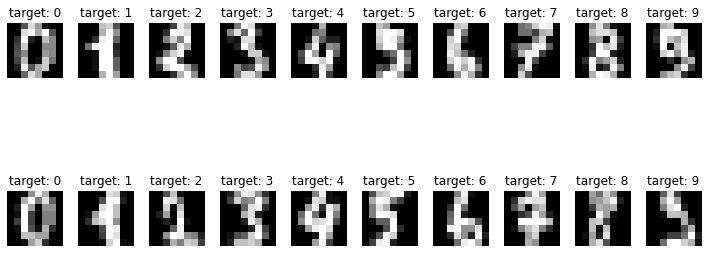

In [ ]:
fig, axes = plt.subplots(2, 10, figsize=(10, 6))
for i in range(20):
    axes[i//10, i %10].imshow(mnist.images[i], cmap='gray');
    axes[i//10, i %10].axis('off')
    axes[i//10, i %10].set_title(f"target: {mnist.target[i]}")
    
plt.tight_layout()

We know that each image is made of pixels and a image can be represeted as a matrix. Bellow image is a close look of a grayscale image. Each pixel is has a value which represents it's brightness. This image can be represented as a 2-d matrix.

<p align="center">
  <img src="https://www.saraai.com/images/blog/mnist1.png" />
</p>
In our dataset, we have grayscale images of 8X8 pixels.

### Split data in train and test

The train-test split technique is used to evaluate model performance after training. 

The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.

- **Train Dataset**: Used to fit the machine learning model.

- **Test Dataset**: Used to evaluate the fit machine learning model.
The objective is to estimate the performance of the machine learning model on 
- **unseen data**: data not used to train the model.

In practice, model is expected for prediction on new unseen data. That is why we make a subset of unseen data for evaluation of model.

Here we are doing 80:20 split for train and test data



In [103]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=seed)
# images = images.reshape(n_images,-1)
# images = (images - images.min()) / (images.max() - images.min())
print("Train size : ",X_train.shape[0])
print("Test size  : ",X_test.shape[0])

Train size :  1437
Test size  :  360


## Multi Layer Perceptron

Multilayer perceptron is feedforward neural network which has structure like this. 

<p align="center">
  <img src="https://nasirml.files.wordpress.com/2017/12/mlp2_model.png?w=585&h=272" />
</p>

This is image of neural network of two hidden layers. The first layer is called **Input layer** which consists data from the sample. The last layer is **Output layer** which is prediction of the network.

## Implementation of Model

In [ ]:
def init_params(layer_sizes,seed):
    n_layers = len(layer_sizes)
    parent_key = random.PRNGKey(seed)
    params = []
    keys = random.split(parent_key,num = n_layers - 1)

    for i in range(n_layers-1):
        w_key,b_key = random.split(keys[i])
        in_size = layer_sizes[i]
        out_size = layer_sizes[i+1]

        W = random.normal(w_key,shape=(in_size,out_size))
        b = random.normal(b_key,shape=(out_size,))
        params.append(dict(weights=W,biases=b))
    return params

In [ ]:
def forward(params,x):
    """
        forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation

        Arguments:
        X -- data, numpy array of shape (input size, number of examples)
        parameters -- output of initialize_parameters_deep()

        Returns:
        AL -- last post-activation value
        caches -- list of caches containing:
        every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
        the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """
    activation = x

    hidden_layers = params[:-1]

    # Loop over the ReLU hidden layers
    for layer in hidden_layers:
        z = np.dot(activation,layer['weights']) + layer['biases']
        activation = jax.nn.relu(z)

    # Perform final trafo to logits
    last_layer = params[-1]
    logits = np.dot(activation,last_layer['weights']) + last_layer['biases']
    output = jax.nn.log_softmax(logits)

    return output

batch_forward = jit(vmap(forward, in_axes=(None, 0)))

In [ ]:
@jit
def loss_fn(params, X, Y):
    """ Compute the multi-class cross-entropy loss """
    prediction = batch_forward(params, X)
    return -np.sum(Y * prediction)

In [ ]:
@jit
def grad_calculation(params, X, Y):
    gradients = grad(loss_fn)(params, X, Y)
    return gradients

def update_param(p,g,lr = 1e-5):
    return p - lr * g

@jit
def gradient_decend(parameters,gradients):
    return jax.tree_map(
        update_param,
        parameters, gradients
    )


def predict(params, X):
    predictions = batch_forward(params,X)
    labels = np.argmax(batch_forward(params, X), axis=-1)
    return labels

def accuracy(params, X, Y):
    Y_hat = predict(params, X)
    return np.mean(Y == Y_hat)

### Training loop

In [ ]:
epochs = 100
batch_size = 256

layers = [X_train.shape[-1],64,32,n]

params = init_params(layers,42)
# print(params)
no_of_samples = X_train.shape[0]
no_of_batches = no_of_samples // batch_size

train_loss = []
for e in trange(epochs):
    total_loss = 0
    acc = 0
    for batch_i in range(0,no_of_samples,batch_size):
        batch_end_idx = batch_i + batch_size if not batch_i + batch_size > no_of_samples + 1 else -1
        batch_images = X_train[batch_i: batch_end_idx]
        batch_labels = y_train[batch_i: batch_end_idx]
        batch_labels_encoded = jax.nn.one_hot(batch_labels, len(mnist['target_names']))
        
        batch_images = jax.device_put(batch_images)  # push NumPy explicitly to GPU
        batch_labels_encoded = jax.device_put(batch_labels_encoded)

        loss = loss_fn(params, batch_images, batch_labels_encoded)
        grads = grad_calculation(params, batch_images, batch_labels_encoded)
        params = gradient_decend(params,grads)
        total_loss += loss
        acc += accuracy(params, batch_images, batch_labels)
    
    train_loss.append(total_loss)

  
    # print("\nTotal loss is -",total_loss)
    # print("\nAccuracy - ", acc/no_of_batches)
    # epoch_range.set_description(f"Total Loss {(total_loss)} - total Accuracy {acc/no_of_batches}" )
    # epoch_range.refresh() # to show immediately the update

100%|██████████| 100/100 [00:01<00:00, 60.33it/s]


In [ ]:
3test_accuracy = accuracy(params,X_test,y_test)

DeviceArray(0.6888889, dtype=float32)

(1797, 64)

In [ ]:
# def MLPClassfier():
#     def __init__(self,layer_sizes,seed):
#         self.parent_key = random.PRNGKey(seed)
#         self.params = []
#         self.layer_sizes = layer_sizes
#         self.n_layers = len(self.layer_sizes)
#         self._init_params()
#         self.caches = []

#     def _init_params(self,scale = 0.01):
#         keys = random.split(self.parent_key,num = self.n_layers - 1)

#         for i in range(self.n_layers-1):
#             w_key,b_key = random.split(keys[i])
#             in_size = self.layer_sizes[i]
#             out_size = self.layer_sizes[i+1]

#             w = random.normal(w_key,shape=(in_size,out_size))
#             b = random.normal(b_key,shape=(out_size,))
#             self.params.append([w,b])

#     def _linear_forward(self,activation,w,b):
#         """
#             for a single sample
#         """
#         z = np.dot(w,activation) + b 
#         cache = (activation,w,b)
#         return z, cache
    
#     def _linear_activation_forward(self,activation, w, b, activation_fn):
#         z, linear_cache = self._linear_forward(activation, w, b)
#         activation = activation_fn(z)
#         cache = (linear_cache, z)

#         return activation, cache

#     @jit
#     def _forward(self,x):
#         """
#         forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
        
#         Arguments:
#         X -- data, numpy array of shape (input size, number of examples)
#         parameters -- output of initialize_parameters_deep()
        
#         Returns:
#         AL -- last post-activation value
#         caches -- list of caches containing:
#                     every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
#                     the cache of linear_sigmoid_forward() (there is one, indexed L-1)
#         """

       
#         activation = x
#         # self.
#         L = self.n_layers                # number of layers in the neural network
    

#         hidden_layers = params[:-1]

#         # Loop over the ReLU hidden layers
#         for w, b in hidden_layers:
#             activation, cache = self._linear_activation_forward(activation, w, b, activation_fn = jax.nn.relu)
#             self.caches.append(cache)

#         # Perform final trafo to logits
#         final_w, final_b = params[-1]
#         logits = np.dot(final_w, activation) + final_b
#         output, cache = self._linear_activation_forward(activation, final_w, final_b, activation_fn = jax.nn.softmax)
#         output = jax.nn.softmax(logits)
#         self.caches.append(cache)

#         return output

#     def forward(self,X):
#         batch_forward = jit(vmap(self._forward, in_axes=(None, 0), out_axes=0))
#         return batch_forward(X)

#     def linear_backward(self, dZ, cache):
#         """
#         Implement the linear portion of backward propagation for a single layer (layer l)

#         Arguments:
#         dZ -- Gradient of the cost with respect to the linear output (of current layer l)
#         cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

#         Returns:
#         dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
#         dW -- Gradient of the cost with respect to W (current layer l), same shape as W
#         db -- Gradient of the cost with respect to b (current layer l), same shape as b
#         """
#         A_prev, W, b = cache
#         m = A_prev.shape[1]

#         ### START CODE HERE ### (≈ 3 lines of code)
#         dW = np.dot(dZ, cache[0].T) / m
#         db = np.squeeze(np.sum(dZ, axis=1, keepdims=True)) / m
#         dA_prev = np.dot(cache[1].T, dZ)
#         ### END CODE HERE ###
        
#         assert (dA_prev.shape == A_prev.shape)
#         assert (dW.shape == W.shape)
#         assert (isinstance(db, float))
        
#         return dA_prev, dW, db

In [ ]:
# forward pass
@jit
def forward(params,in_array):
    """
        Compute the forward pass for each example individually
        params: list of weights and biases of MLP 
        x: single flat image
    """
    hidden_layers = params[:-1]

    activations = in_array

    # Loop over the ReLU hidden layers
    for w, b in hidden_layers:
        a = np.dot(w,activations) + b 
        activation = jax.nn.relu(a)
    
    # Perform final trafo to logits
    final_w, final_b = params[-1]
    logits = np.dot(final_w, activations) + final_b
    output = jax.nn.softmax(logits)
    return output


In [ ]:
def update(params,imgs,labels):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)


In [ ]:
def init_MLPClassfier(layer_sizes,parent_key,scale = 0.01):
    params = []
    keys = random.split(parent_key,num= len(layer_sizes) - 1)

    for i in range(len(layer_sizes)-1):
        w_key,b_key = random.split(keys[i])
        in_size = layer_sizes[i]
        out_size = layer_sizes[i+1]
        w = random.normal(w_key,shape=(in_size,out_size))
        b = random.normal(b_key,shape=(out_size,))
        params.append([w,b])

    return params

In [ ]:
# test
input,h1,h2,output = (784,512,256,10)
layers = [input,h1,h2,output]
seed = 42 

parent_key = random.PRNGKey(seed)
MLP_params = init_MLPClassfier(layers,parent_key)

print(jax.tree_map(lambda x: x.shape,MLP_params))